Authors: Aaryan Mahipal, Amelia Roopnarine 

STEP 1: Data Preperation

In [14]:
# Task 1.1: Load and Explore the Data

import numpy as np
import matplotlib.pyplot as plt

# Define the function to load the fluid flow data
def load_fluid_flow_data(file_path):
    """
    Load fluid flow data from a file and return it as a numpy array.
    
    Parameters:
    file_path (str): Path to the data file
    
    Returns:
    np.array: 3D array of shape (n_timesteps, n_x, n_y) containing fluid flow data
    """
    return np.load(file_path)

# Load the dataset
file_path = 'cylinder_flow_data.npy'
fluid_flow_data = load_fluid_flow_data(file_path)


In [15]:
def plot_flow_field(flow_data, timestep):
    """
    Plot the flow field at a given timestep.
    
    Parameters:
    flow_data (np.array): 3D array of fluid flow data
    timestep (int): Timestep to plot
    """
    # Ensure the timestep is within the bounds of the data
    if timestep < 0 or timestep >= flow_data.shape[0]:
        raise ValueError(f"Timestep must be between 0 and {flow_data.shape[0] - 1}.")
    
    # Extract the flow field for the given timestep
    flow_field = flow_data[timestep]
    
    # Plot the flow field using imshow
    plt.figure(figsize=(8, 4))
    plt.imshow(flow_field, extent=[-2, 4, -1, 1], aspect='equal', cmap='viridis')
    plt.colorbar(label='Flow Field Value')
    plt.title(f'Flow Field at Timestep {timestep}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

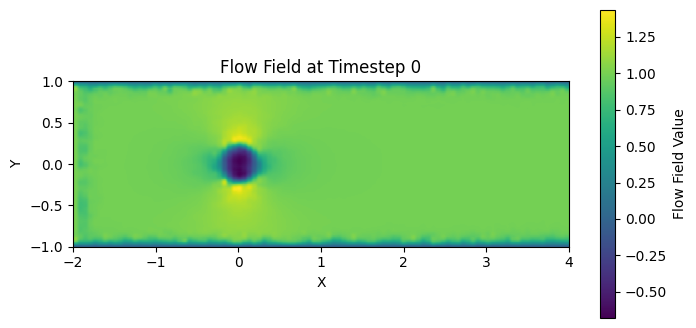

In [16]:
# Example usage
data = load_fluid_flow_data('cylinder_flow_data.npy')
plot_flow_field(data, timestep=0)

In [17]:
# Task 1.2: Reshape the data for DMD
def reshape_for_dmd(flow_data):
    """
    Reshape 3D flow data into a 2D matrix suitable for DMD.
    
    Parameters:
    flow_data (np.array): 3D array of shape (n_timesteps, n_x, n_y)
    
    Returns:
    np.array: 2D array of shape (n_x * n_y, n_timesteps)
    """
    # Get the shape of the 3D data
    n_timesteps, n_x, n_y = flow_data.shape
    
    # Reshape into a 2D array with each column as a flattened snapshot for each timestep
    reshaped_data = flow_data.reshape(n_timesteps, n_x * n_y).T
    return reshaped_data

# Apply the reshape function to the fluid flow data
dmd_data_matrix = reshape_for_dmd(fluid_flow_data)

# Check the shape of the reshaped data for verification
dmd_data_matrix.shape


(10000, 100)

STEP 2: Implementing the DMD Algorithm 

In [18]:
# Task 2.1: Compute the DMD Matrices
def compute_dmd_matrices(X):
    """
    Compute the matrices needed for DMD analysis.
    
    Parameters:
    X (np.array): 2D data matrix of shape (n_features, n_samples)
    
    Returns:
    tuple: (X1, X2) where X1 is X[:, :-1] and X2 is X[:, 1:]
    """
    X1 = X[:, :-1]  # All columns except the last
    X2 = X[:, 1:]   # All columns except the first
    return X1, X2

def compute_svd(X):
    """
    Compute the Singular Value Decomposition (SVD) of a matrix.
    
    Parameters:
    X (np.array): 2D matrix
    
    Returns:
    tuple: (U, S, Vt) - The SVD components
    """
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return U, S, Vt


In [19]:
# Example usage and validity checks
import numpy as np
# Test compute_dmd_matrices
X_test = np.random.rand(10, 5)
X1, X2 = compute_dmd_matrices(X_test)
assert X1.shape == (10, 4), "X1 should have one less column than X"
assert X2.shape == (10, 4), "X2 should have one less column than X"
assert np.array_equal(X1, X_test[:, :-1]), "X1 should be all but the last column of X"
assert np.array_equal(X2, X_test[:, 1:]), "X2 should be all but the first column of X"

# Test compute_svd
X_svd_test = np.random.rand(10, 5)
U, S, Vt = compute_svd(X_svd_test)
assert U.shape == (10, 5), "U should have the same number of rows as X and min(X.shape) columns"
assert S.shape == (5,), "S should have length min(X.shape)"
assert Vt.shape == (5, 5), "Vt should be square with size min(X.shape)"
assert np.allclose(np.dot(U * S, Vt), X_svd_test), "SVD decomposition should satisfy X = U * S * Vt"
assert np.allclose(np.dot(U.T, U), np.eye(5)), "U should be orthonormal"
assert np.allclose(np.dot(Vt, Vt.T), np.eye(5)), "Vt should be orthonormal"

print("All tests passed successfully!")

All tests passed successfully!


In [20]:
# Task 2.2: Compute DMD modes and eigenvalues

def compute_dmd_modes_and_eigenvalues(U, S, Vt, X2):
    """
    Compute the DMD modes and eigenvalues.

    Parameters:
    U, S, Vt (np.array): SVD components of X1
    X2 (np.array): Second snapshot matrix

    Returns:
    tuple: (modes, eigenvalues)
    """
    # Step 1: Compute the pseudoinverse of S as a diagonal matrix
    S_inv = np.diag(1 / S)
    
    # Step 2: Compute the approximate linear operator A
    A_tilde = np.dot(np.dot(np.dot(U.T, X2), Vt.T), S_inv)

    # Step 3: Compute the eigenvalues and eigenvectors of A_tilde
    eigenvalues, W = np.linalg.eig(A_tilde)
    
    # Step 4: Compute the DMD modes
    modes = np.dot(np.dot(np.dot(X2, Vt.T), S_inv), W)

    return modes, eigenvalues


STEP 3: Applying DMD to Fluid Flow Data

In [21]:
def perform_dmd(flow_data, r=10):
    """
    Perform DMD on the fluid flow data.

    Parameters:
    flow_data (np.array): 3D array of fluid flow data
    r (int): Number of modes to retain

    Returns:
    tuple: (modes, eigenvalues, dynamics)
    """
    # Reshape flow_data to a 2D matrix X
    n_x, n_y, n_t = flow_data.shape
    X = flow_data.reshape(n_x * n_y, n_t)  # Shape: (n_features, n_snapshots)
    
    # Split X into X1 and X2 for DMD computation
    X1 = X[:, :-1]  # All columns except the last
    X2 = X[:, 1:]   # All columns except the first
    
    # Step 2: Perform SVD on X1
    U, S, Vt = np.linalg.svd(X1, full_matrices=False)
    U_r = U[:, :r]
    S_r = np.diag(S[:r])
    V_r = Vt[:r, :].T
    
    # Step 3: Compute the DMD operator A_tilde
    # Ensure shapes are aligned for multiplication
    A_tilde = U_r.T @ X2 @ V_r @ np.linalg.inv(S_r)
    
    # Step 4: Eigendecomposition of A_tilde
    eigenvalues, W = np.linalg.eig(A_tilde)
    
    # Step 5: Compute DMD modes
    modes = X2 @ V_r @ np.linalg.inv(S_r) @ W

    # Step 6: Compute DMD dynamics
    dt = 1 / 100  # Assuming a time step of 0.01
    omega = np.log(eigenvalues) / dt  # Continuous-time eigenvalues
    t = np.arange(n_t) * dt           # Time vector
    dynamics = np.exp(np.outer(omega, t))  # Time dynamics

    return modes, eigenvalues, dynamics


STEP 4: Visualizing and Interpreting Results

In [22]:
# Task 4.1: Visualize DMD Modes

def plot_dmd_mode(mode, shape):
    """
    Plot a single DMD mode for fluid flow around a cylinder.
    
    Parameters:
    -----------
    mode (np.array): 1D array representing a DMD mode
        Complex-valued array that will be reshaped to 2D.
        Only the real part will be visualized.
    
    shape (tuple): Original shape of the flow field (n_x, n_y)
        Dimensions to reshape the mode into its 2D representation.

    Expected Output:
    ---------------
    A single figure (10x8 inches) showing:
    - 2D visualization of the DMD mode
    - Grayscale colormap
    - Physical domain extent: x=[-2,4], y=[-1,1]
    - Cylinder shown as black circle at origin (radius=0.2)
    - Colorbar showing mode magnitude
    - Axis labels 'x' and 'y'
    - Title "DMD Mode"
    """
    # Reshape the mode to a 2D field
    mode_2d = np.real(mode).reshape(shape)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    plt.imshow(
        mode_2d, cmap='gray', extent=[-2, 4, -1, 1], aspect='equal'
    )
    
    # Add the cylinder at the origin
    cylinder = plt.Circle((0, 0), radius=0.2, color='black')
    plt.gca().add_patch(cylinder)
    
    # Add colorbar and labels
    plt.colorbar(label="Mode Magnitude")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("DMD Mode")
    plt.show()


In [23]:
def plot_mode_frequencies(eigenvalues, dt):
    """
    Plot the frequencies and growth rates of DMD modes.
    
    Parameters:
    -----------
    eigenvalues (np.array): DMD eigenvalues
        Complex-valued array containing temporal information.
        Used to compute frequencies and growth rates.
    
    dt (float): Time step between snapshots.
        Time interval between data frames.
        Used to convert eigenvalues to physical frequencies.

    Expected Output:
    ---------------
    A single figure (10x5 inches) showing:
    - Scatter plot of mode frequencies vs growth rates
    - X-axis: Frequencies (computed as imag(log(λ))/(2π*dt))
    - Y-axis: Growth rates (computed as real(log(λ))/dt)
    - Red dashed line at y=0 separating growing/decaying modes
    - Grid lines for better readability
    """
    # Compute growth rates and frequencies
    growth_rates = np.real(np.log(eigenvalues)) / dt
    frequencies = np.imag(np.log(eigenvalues)) / (2 * np.pi * dt)
    
    # Set up the plot
    plt.figure(figsize=(10, 5))
    plt.scatter(frequencies, growth_rates, color='b', label='DMD Modes')
    
    # Add red dashed line at y=0 to separate growing/decaying modes
    plt.axhline(0, color='r', linestyle='--', linewidth=1)
    
    # Labels, title, and grid for readability
    plt.xlabel("Frequency")
    plt.ylabel("Growth Rate")
    plt.title("DMD Mode Frequencies and Growth Rates")
    plt.grid(True)
    plt.legend()
    
    plt.show()


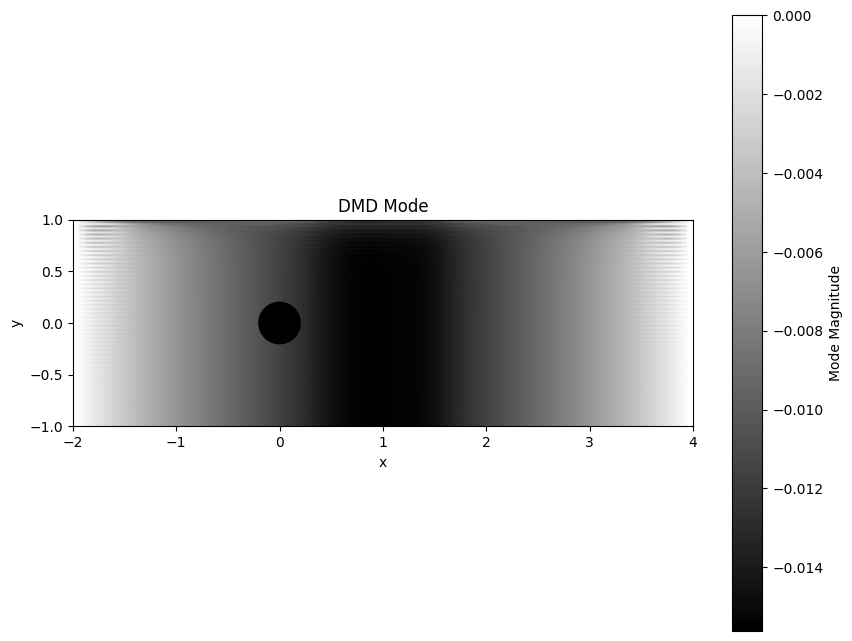

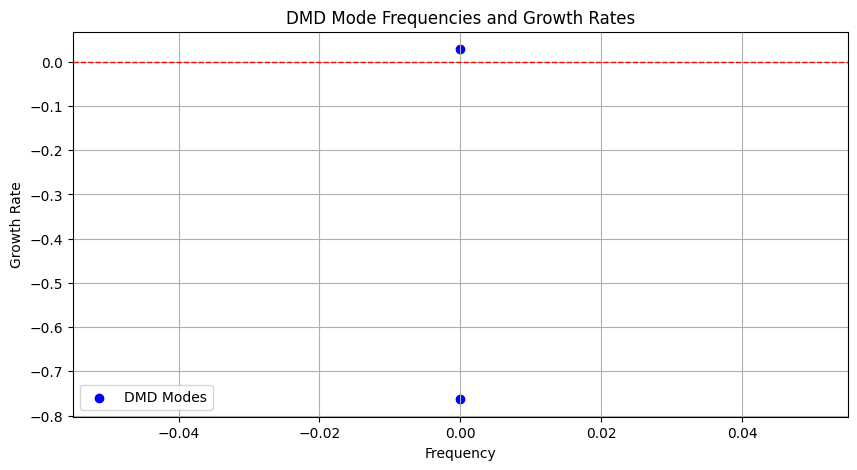

In [24]:
# Example use
# Testing the functions using the first 2 modes
flow_data = load_fluid_flow_data('cylinder_flow_data.npy')
modes, eigenvalues, dynamics = perform_dmd(flow_data, r=2)
plot_dmd_mode(modes[:,0], shape=(100,100))
dt = 0.01  # Assuming time step of 0.01
plot_mode_frequencies(eigenvalues, dt)

In [25]:
# Task 4.2: Reconstruct and Compare Flow Fields

def reconstruct_flow_field(modes, dynamics, timestep):
    """
    Reconstruct the flow field at a given timestep using DMD.
    
    Parameters:
    -----------
    modes (np.array): DMD modes, shape (n_features, n_modes)
    dynamics (np.array): DMD mode dynamics, shape (n_modes, n_timesteps)
    timestep (int): Timestep to reconstruct
    
    Returns:
    --------
    np.array: Reconstructed flow field, reshaped to (n_x, n_x)
    """
    # Ensure timestep is within bounds
    assert timestep < dynamics.shape[1], "Timestep exceeds available range."
    
    # Select the amplitude at the given timestep
    b_k = dynamics[:, timestep]
    
    # Reconstruct the flow field at this timestep
    x_k = modes @ b_k
    
    # Reshape to 2D square domain
    n_features = modes.shape[0]
    n_x = int(np.sqrt(n_features))
    flow_field = np.real(x_k).reshape((n_x, n_x))
    
    return flow_field


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_original_and_reconstructed(original, reconstructed):
    """
    Compare the original and reconstructed flow fields visually and quantitatively.
    
    Parameters:
    -----------
    original (np.array): Original flow field, shape (n_x, n_x)
    reconstructed (np.array): Reconstructed flow field, shape (n_x, n_x)
    """
    # Calculate error metrics
    mse = mean_squared_error(original, reconstructed)
    mae = mean_absolute_error(original, reconstructed)
    relative_error = np.linalg.norm(original - reconstructed) / np.linalg.norm(original)
    
    # Print error metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Relative Error: {relative_error:.4f}")
    
    # Plot original and reconstructed flow fields
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the original flow field
    im1 = ax1.imshow(original, cmap='coolwarm', extent=[-2, 4, -1, 1])
    ax1.set_title("Original Flow Field")
    fig.colorbar(im1, ax=ax1, orientation="vertical")
    
    # Plot the reconstructed flow field
    im2 = ax2.imshow(reconstructed, cmap='coolwarm', extent=[-2, 4, -1, 1])
    ax2.set_title("Reconstructed Flow Field")
    fig.colorbar(im2, ax=ax2, orientation="vertical")
    
    # Suptitle with relative error
    fig.suptitle(f"Flow Field Comparison\nRelative Error: {relative_error:.4f}", fontsize=16)
    
    # Layout adjustments
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.show()


Mean Squared Error (MSE): 1.1801656047749325
Mean Absolute Error (MAE): 0.9951398508646117
Relative Error: 1.0081


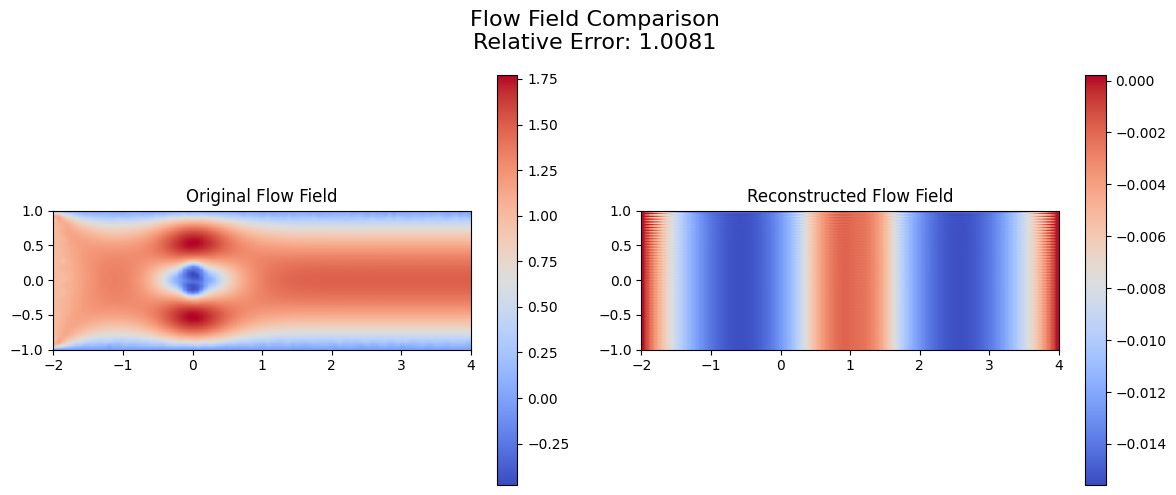

In [27]:
# Example usage:
# Load original data
original_data = load_fluid_flow_data('cylinder_flow_data.npy')
# Perform DMD 
modes, eigenvalues, dynamics = perform_dmd(original_data, r=10)  # r is the number of modes to retain

# Choose a timestep to reconstruct
timestep = 50  # for example

# Reconstruct the flow field
reconstructed_field = reconstruct_flow_field(modes, dynamics, timestep)
# Compare original and reconstructed fields
compare_original_and_reconstructed(original_data[timestep], reconstructed_field)